In [7]:
import sys
sys.path.append("..")

# Multi-particle tracking with U-net

This notebook creates and trains a model for tracking multiple particles.

The model receives as an input an image that may or may not contain particles and outputs an image of the same shape, with pixel-values between 0 and 1. A pixel with a value closer to one indicate a high confidence that there is a particle close to that pixel, while values close to zero inicate a high confidence that there is no nearby particle. 

## Defining the feature series

In [8]:
# Import all classes that are needed for this example
from deeptrack.scatterers import PointParticle
from deeptrack.optics import OpticalDevice
from deeptrack.image import Image
from deeptrack.noises import Poisson, Offset

import numpy as np
import matplotlib.pyplot as plt


Optics = OpticalDevice(
    NA=0.7,                
    pixel_size=0.1e-6,     
    wavelength=680e-9
)

particle = PointParticle(                                         
    intensity=100,
    position=lambda: np.random.rand(2) * 256,
    position_unit="pixel"
)

poisson_noise = Poisson(
    snr=np.linspace(10,30)
)

offset = Offset(
    offset=lambda: np.random.rand()*20
)

num_particles = list(range(1,10)) 

# A random number of particles between 1 and 10 + a background offset, with poisson noise 
feature_series = Optics(particle**num_particles + offset) + poisson_noise


In [9]:
# Visualize the input space
for i in range(4):
    feature_series.update()
    output_image = feature_series.plot((256,256))

AttributeError: 'Branch' object has no attribute 'plot'

### Define the model architecture

In [6]:
from deeptrack.models import unet
from deeptrack.losses import weighted_crossentropy, sigmoid, flatten
from deeptrack.generators import Generator

import tensorflow.keras.backend as K
from tensorflow import keras


# Creates a the ground truth from the generated image.
def get_label(image):
    label = np.zeros(image.shape)
    X, Y = np.meshgrid(np.arange(0,image.shape[0]), np.arange(0,image.shape[1]))
    for property in image.properties:
        if property["name"] == "PointParticle":
            position = property["position"]
            distance_map = (X - position[0])**2 + (Y - position[1])**2
            label[distance_map < 5] = 1
    return np.expand_dims(label,axis=-1)
        

generator = Generator().generate(feature_series, get_label, shape=(256,256), batch_size=16)
validation_generator = Generator().generate(feature_series, get_label, shape=(256,256), batch_size=1)

model = unet((256,256,1), conv_layers_dimensions=[16,32,32,32], loss=flatten((weighted_crossentropy((90,1)))))


Instructions for updating:
Colocations handled automatically by placer.


### Fit the model, then visualize

In [7]:
model.fit(generator, epochs=20, steps_per_epoch=10)

Epoch 1/20


..\deeptrack\optics.py:135: RuntimeWarning: invalid value encountered in power
  pupil = (RHO < 1) / ((1 - NA**2 / refractive_index_medium**2 * RHO)**0.25)
..\deeptrack\optics.py:139: RuntimeWarning: invalid value encountered in sqrt
  z_shift = 2 * np.pi * refractive_index_medium/wavelength * (1 - NA**2 / refractive_index_medium**2 * RHO)**0.5 * pixel_size * defocus


10/10 [==============================] - 9s 882ms/step - loss: 0.0072
Epoch 2/20
10/10 [==============================] - 8s 847ms/step - loss: 0.0061
Epoch 3/20
10/10 [==============================] - 9s 870ms/step - loss: 0.0052
Epoch 4/20
10/10 [==============================] - 9s 860ms/step - loss: 0.0034
Epoch 5/20
10/10 [==============================] - 8s 849ms/step - loss: 0.0017
Epoch 6/20
10/10 [==============================] - 8s 848ms/step - loss: 5.7248e-04
Epoch 7/20
10/10 [==============================] - 8s 845ms/step - loss: 3.0304e-04
Epoch 8/20
10/10 [==============================] - 8s 846ms/step - loss: 2.5133e-04
Epoch 9/20
10/10 [==============================] - 9s 858ms/step - loss: 1.4803e-04
Epoch 10/20
10/10 [==============================] - 9s 858ms/step - loss: 1.2803e-04
Epoch 11/20
10/10 [==============================] - 9s 865ms/step - loss: 1.2834e-04
Epoch 12/20
10/10 [==============================] - 9s 887ms/step - loss: 9.9277e-05
Epoch 13

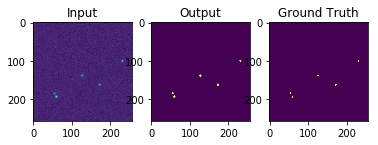

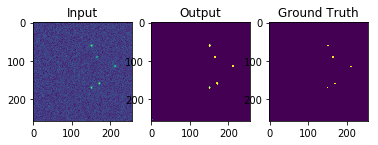

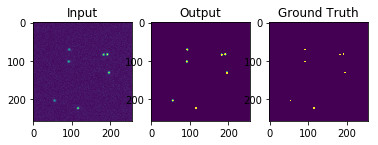

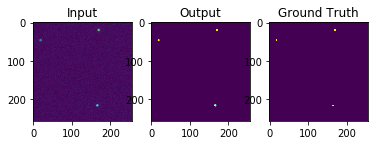

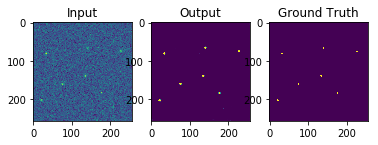

In [11]:
for i in range(5):
    b, l = next(validation_generator)
    p = model.predict(b)
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(b[0,:,:,0]))
    plt.title("Input")
    plt.subplot(1,3,2)
    
    plt.imshow(np.squeeze(p[0,:,:,0]))
    plt.title("Output")
    
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(l[0,:,:,0] > 0.5))
    plt.title("Ground Truth")
    plt.show()